# Simple experiment on synthetic data to validate the method

## Imports

Load the modules needed to run the experiment.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet as mpl
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

## Generate synthetic data

First, we create a regular grid of observation points.

In [35]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 1000, 0, 1000],  # µm
    spacing=1,  # µm
    extra_coords=sensor_sample_distance,
)

Now create the dipole model that will be used to generate the data.

In [36]:
dipole_coordinates = (
    [250,  500, 750,  800],  # µm
    [250,  500, 750,  200],  # µm
    [-3.50, -7.75, -8.50, -10.0],  # µm
)
dipole_moments = np.transpose(
    mg.cartesian_vector(
        inclination=[-30 , -50, 62,  22],
        declination=[-140, -70, 10, 125],
        amplitude=[5e-15, 1e-15, 1.5e-14, 2e-14],
    )
)
dipole_moments

array([[-2.78335200e-15, -3.31706974e-15,  2.50000000e-15],
       [-6.04022774e-16,  2.19846310e-16,  7.66044443e-16],
       [ 1.22284322e-15,  6.93508852e-15, -1.32442139e-14],
       [ 1.51900910e-14, -1.06362162e-14, -7.49213187e-15]])

Calculate the $b_z$ magnetic field of the dipoles and place them into an `xarray.DataArray` for easier handling.

In [37]:
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0 1e+03
  * y        (y) float64 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0 1e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 -0.002845 -0.002867 -0.00289 ... 0.03229 0.03209

Make a quick plot of the calculated field.

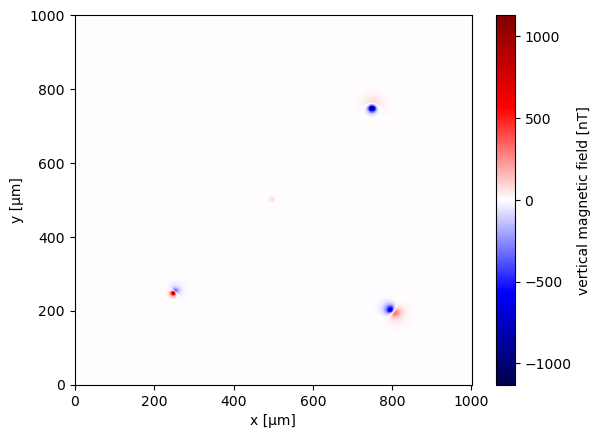

In [38]:
data.bz.plot.pcolormesh(cmap="seismic")

Add some random noise to make it more realistic.

In [39]:
noise_std_dev = 20  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

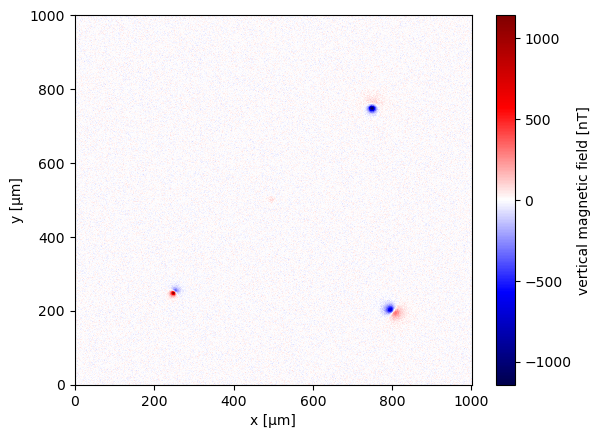

In [40]:
data.bz.plot.pcolormesh(cmap="seismic")

## Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
1. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
1. Contrast stretch the TGA to highlight weaker sources
1. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

### 1. Upward continue the data to suppress the noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [41]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

/home/leo/bin/conda/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0 1e+03
  * x        (x) float64 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0 1e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 0.1556 0.1945 0.2623 0.3371 ... 0.1445 0.1033 0.124

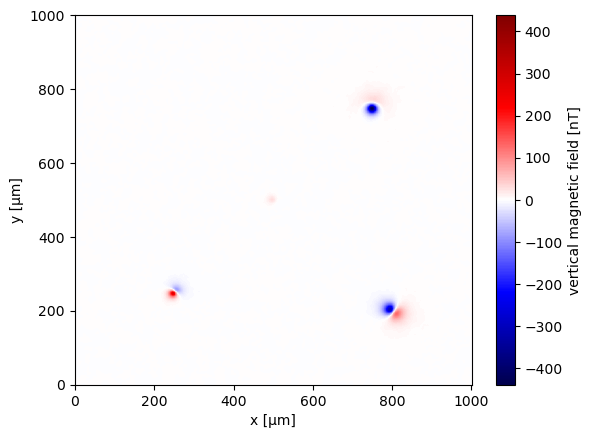

In [42]:
data_up.bz.plot.pcolormesh(cmap="seismic")

### 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [43]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/leo/bin/conda/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/leo/bin/conda/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0 1e+03
  * x        (x) float64 0.0 1.0 2.0 3.0 4.0 ... 996.0 997.0 998.0 999.0 1e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 0.1556 0.1945 0.2623 0.3371 ... 0.1445 0.1033 0.124
    tga      (y, x) float64 0.1422 0.209 0.2538 0.2514 ... 0.1974 0.1359 0.08039
    x_deriv  (y, x) float64 0.03888 0.05335 0.07129 ... -0.01026 0.02071
    y_deriv  (y, x) float64 -0.1149 -0.1755 -0.2014 ... 0.1798 0.1339 0.07631
    z_deriv  (y, x) float64 -0.07422 -0.1002 -0.1369 ... 0.02665 0.0208 -0.0145

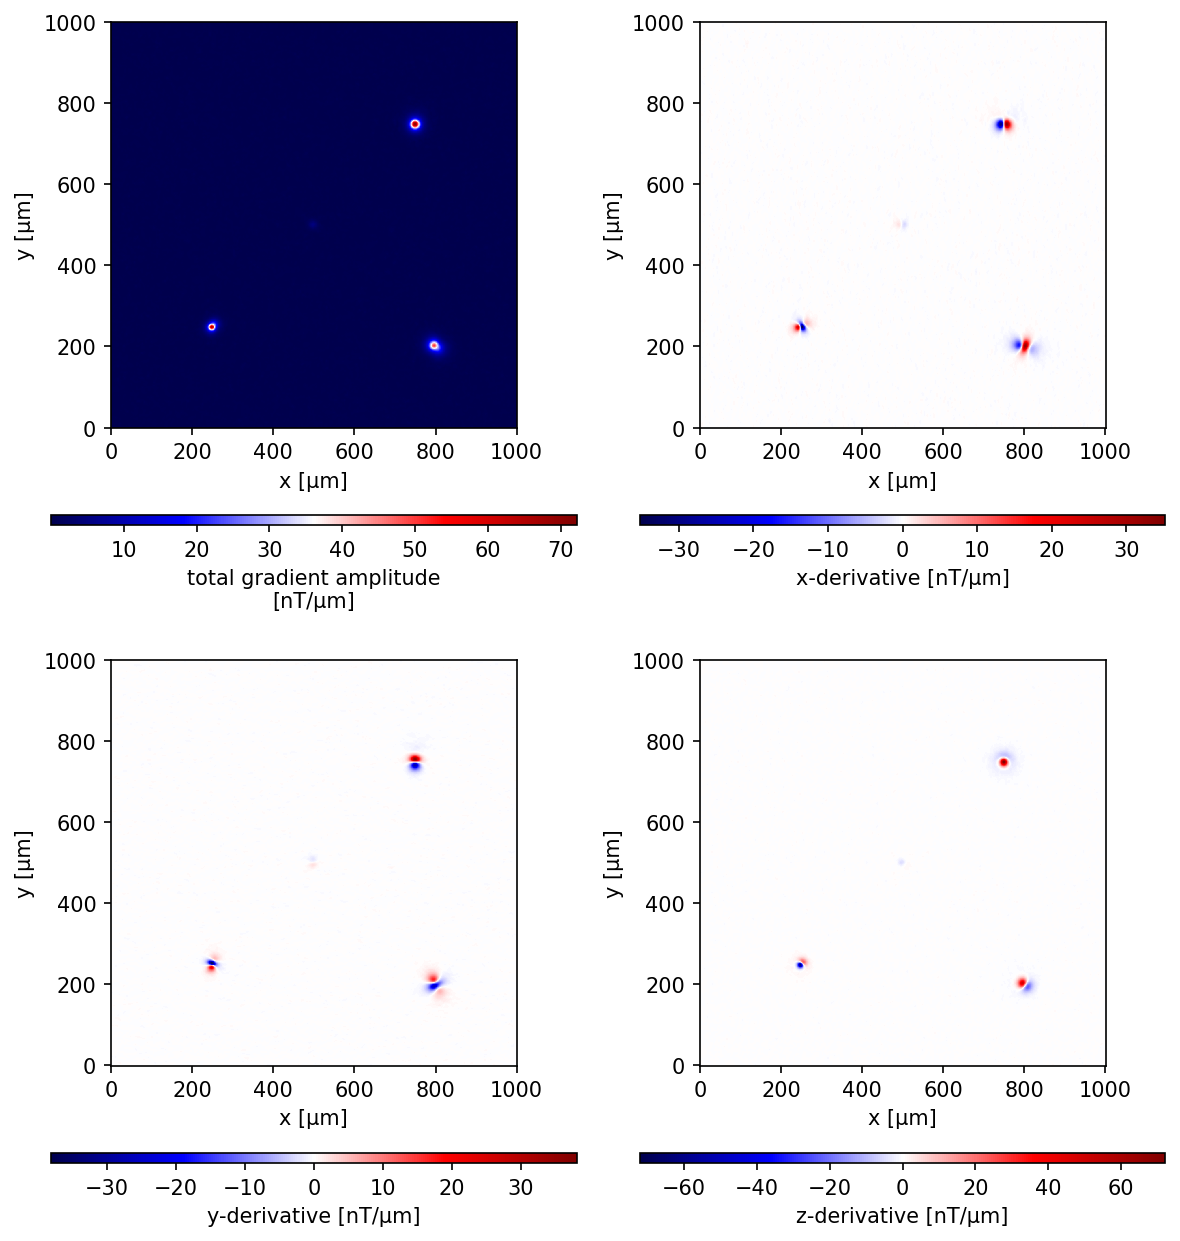

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8.5), dpi=150)
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

### 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [45]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

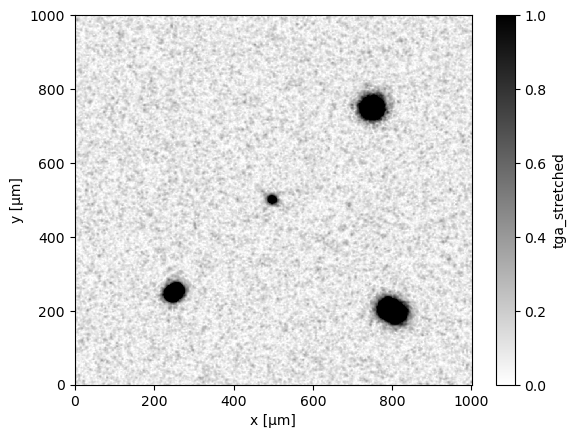

In [46]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

### 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [56]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[10, 100],
    size_increment=2,
    threshold=0.5,
    overlap=0.5,
)
windows

[[665.1471862576143, 834.8528137423857, 665.1471862576143, 834.8528137423857],
 [179.28932188134524,
  320.71067811865476,
  179.28932188134524,
  320.71067811865476],
 [716.1471862576143, 885.8528137423857, 115.1471862576143, 284.8528137423857],
 [469.7157287525381, 526.2842712474619, 472.7157287525381, 529.2842712474619]]

[665.1471862576143, 665.1471862576143]
[179.28932188134524, 179.28932188134524]
[716.1471862576143, 115.1471862576143]
[469.7157287525381, 472.7157287525381]


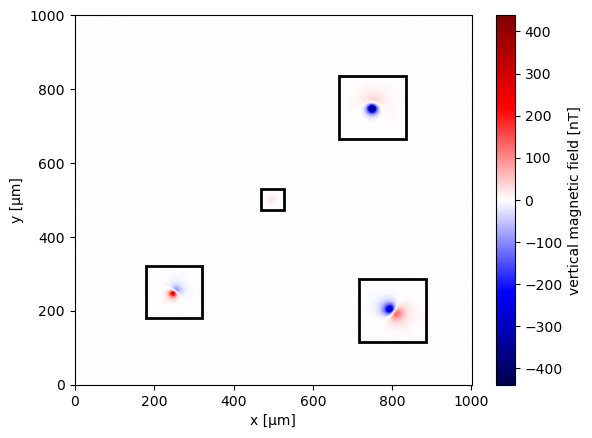

In [57]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    print([window[0], window[2]])
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run  the Euler deconvolution and moment inversion for each anomaly separately.

## Euler Deconvolution

In [58]:
positions = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    print(position, base_level)
    positions.append(position)
positions = np.transpose(positions)

[750.02360941 750.00479138  -8.4089252 ] 0.1131832591831969
[249.97786449 250.08624646  -3.38608503] 0.22391774381211133
[800.01966274 199.89413711  -9.97527759] -0.036838265485181036
[499.06573751 500.55102479  -7.15886612] 0.266877176077985


Find which estimated source corresponds to each actual source.

In [59]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([0.0910748 , 0.11391497, 0.02472241, 0.59113388])

Plot the locations found and the error in z.

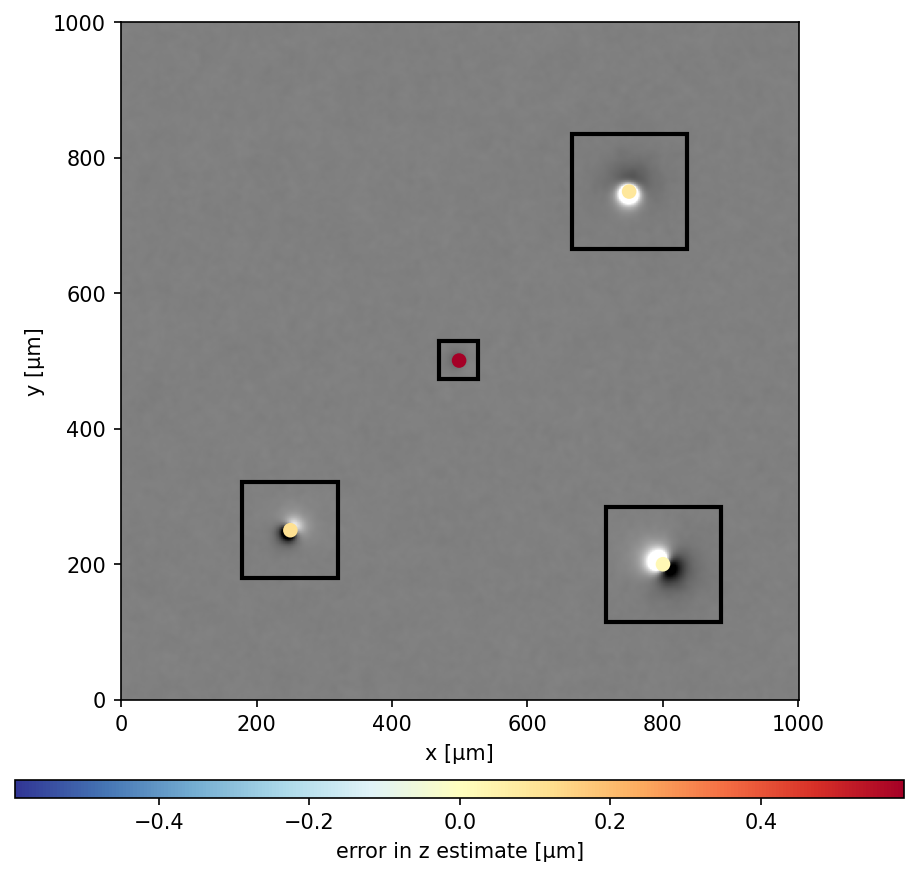

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=150)
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-100, vmax=100, add_colorbar=False)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale)
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

## Dipole moment inversion

With the source positions found through Euler Deconvolution, we can now estimate the dipole moment through a linear inversion.

# Euler solver

Text(0, 0.5, 'Count')

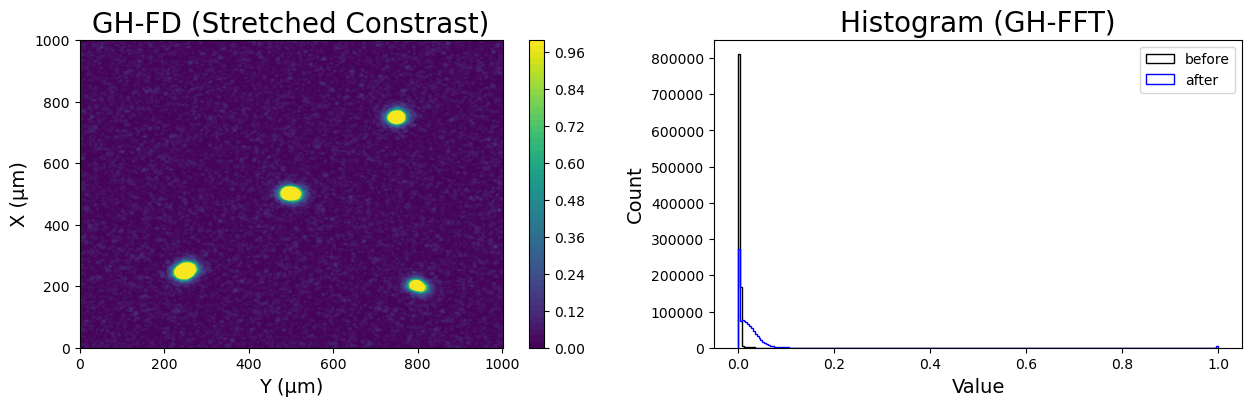

In [20]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (20.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))


fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='viridis')
ax1.set_title('GH-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (GH-FFT)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)

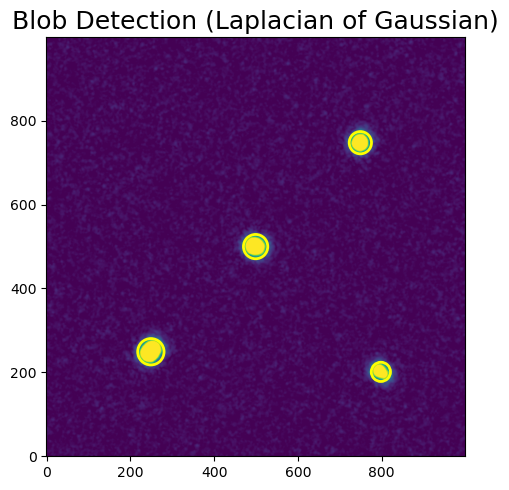

Sources found  =  4


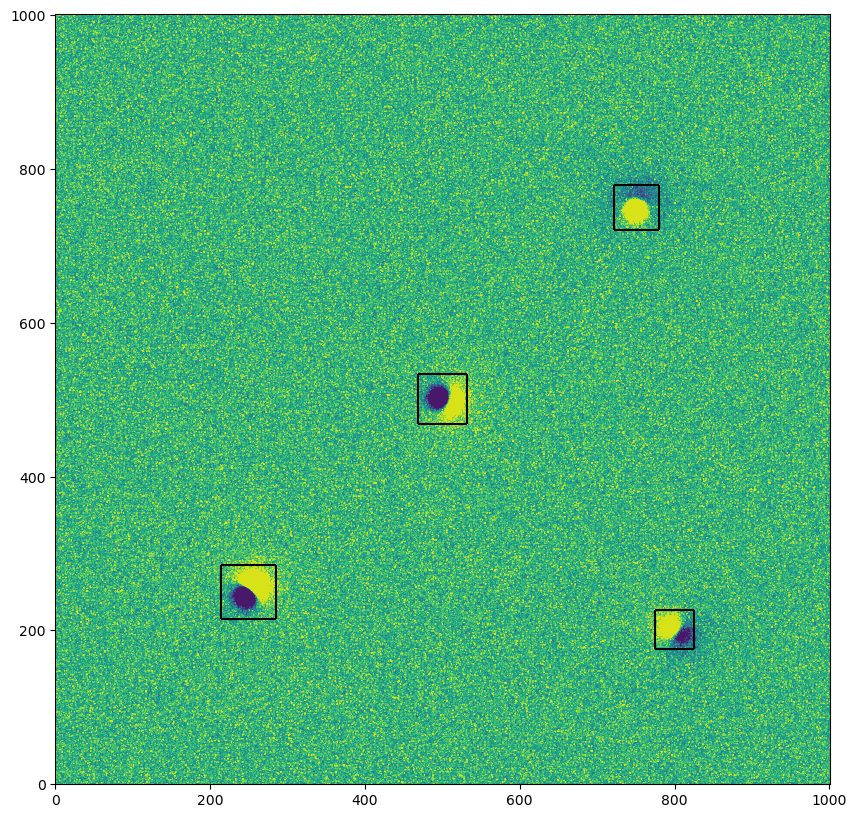

In [21]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.5, min_sigma=5, 
                                              max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=0.1)

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_2D, Y_2D, Z_2D, upward,
                                                                     X_derivative_FD, Y_derivative_FD, Z_derivative_FD,
                                                                     delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(data_2D, (0.5,99.5))
view = skimage.exposure.rescale_intensity(data_2D, in_range=(perc_min, perc_max))
euler_windows_view(X_2D, Y_2D, Z_2D, view, filtered_euler_windows_FD, show_windows=False, color='k')


print('Sources found  = ', np.shape(euler_windows_FD)[0])

Euler Solutions:
    Xc (µm)   Yc (µm)  Zc (µm)
0  250.2773  250.1935   5.3778
1  500.4644  500.5027   7.7679
2  750.7280  750.7204   8.5726
3  200.2960  800.9237  10.0003

Original Positions:
   Xc (µm)  Yc (µm)  Zc (µm)
0    250.0    250.0     5.30
1    500.0    500.0     7.75
2    750.0    750.0     8.50
3    200.0    800.0    10.00



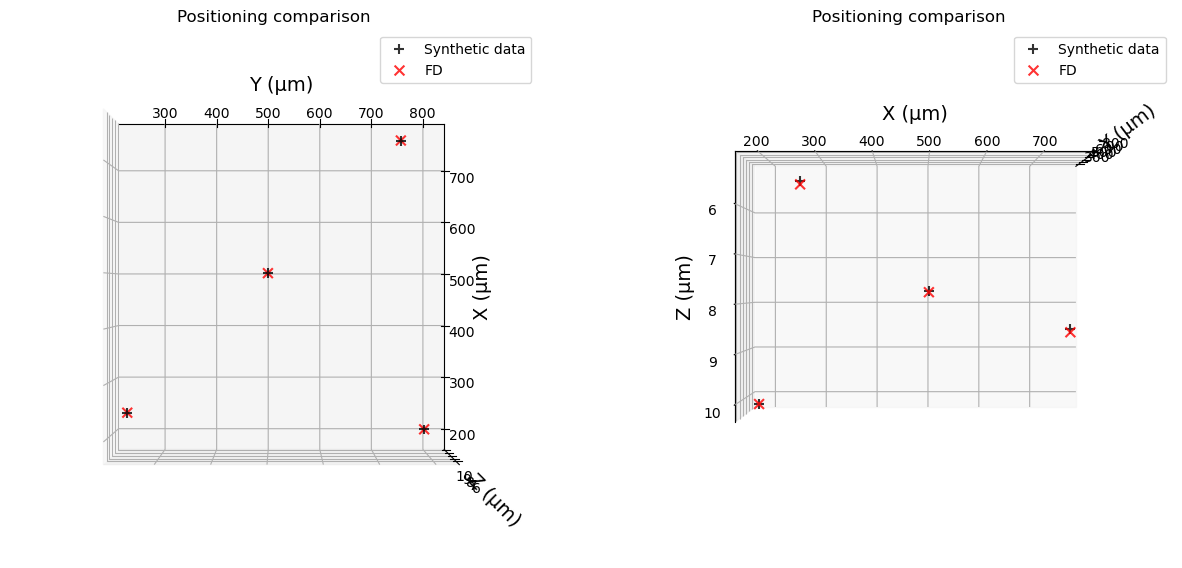

In [22]:
# Read model parameter to compare
model_par = pd.read_csv('model_parameters.csv')

D = model_par['Dec (°)']
I = model_par['Inc (°)']
M = model_par['Mag (A/m)']
R = model_par['Radii (µm)']*microm2m

Xc = model_par['Xc (µm)']*microm2m
Yc = model_par['Yc (µm)']*microm2m
Zc = model_par['Zc (µm)']*microm2m
###############################################

print('Euler Solutions:')
df1 = pd.DataFrame(data={'Xc (µm)': (np.round(Xc_FD*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_FD*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_FD*m2microm, decimals=4))
                       })

print(df1)
print()

print('Original Positions:')

df2 = pd.DataFrame(data={
                        'Xc (µm)': (np.round(Xc*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc*m2microm, decimals=4))
                       })

print(df2)
print()


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc*m2microm, Xc*m2microm, Zc*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90




ax2.scatter(Yc*m2microm, Xc*m2microm, Zc*m2microm, alpha=0.8, color='k', marker='+', s=50, label='Synthetic data')
ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm, alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()

# Magnetic inversion using lest square method

In [23]:
# set the noise level as the measurement standart deviation
noise_std_dev = 15.0e-9 # nT for the 'fixed method'

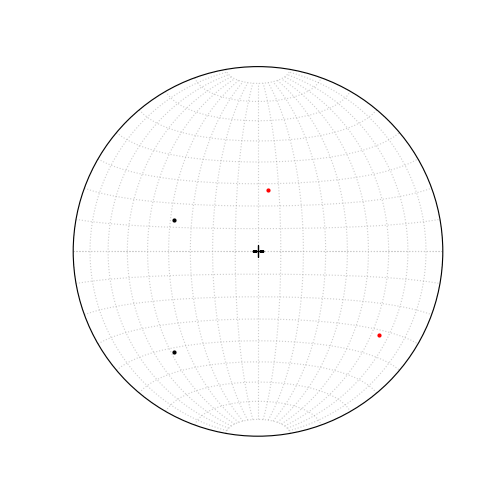

,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,-140.2214,0.1118,-30.0369,0.0766,8.824737e-15,1.394802e-17,250.277286,250.193492,5.377769
1,-69.4163,0.2615,-49.8524,0.1500,7.672073e-15,1.899259e-17,500.464368,500.502720,7.767939
2,9.0604,0.4988,62.3410,0.2187,6.312596e-15,1.988655e-17,750.727970,750.720446,8.572643
3,124.6274,0.3892,21.7600,0.2726,4.939015e-15,3.006855e-17,200.296017,800.923711,10.000332


In [24]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
mx_FD_least, my_FD_least, mz_FD_least, A_FD_least, forward_model_FD_least = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, data)


D_FD_least, I_FD_least = directions(mx_FD_least, my_FD_least, mz_FD_least, plot=True)

#calculate momentum
momentum_FD_least = (np.sqrt(mx_FD_least**2 + my_FD_least**2 + mz_FD_least**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(data))+np.absolute(np.min(data))) * noise_std_dev
sigma_noise = noise_std_dev
sigma_D_FD_least, sigma_I_FD_least, sigma_m_FD_least = uncertainties(sigma_noise, A_FD_least, mx_FD_least, my_FD_least, mz_FD_least)


df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)

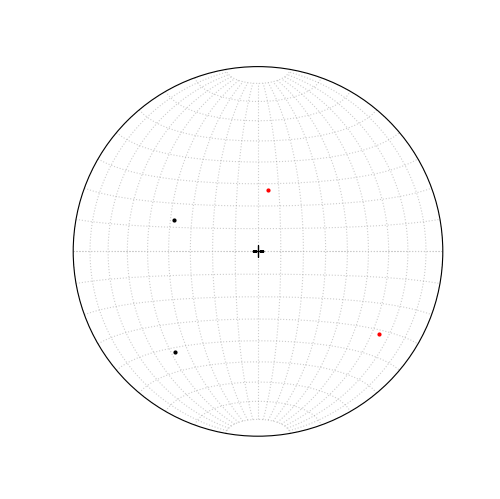

,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,-140.2682,0.2462,-30.0500,0.1686,8.802500e-15,3.062434e-17,250.277286,250.193492,5.377769
1,-69.4346,0.5069,-49.8418,0.2909,7.662416e-15,3.678279e-17,500.464368,500.502720,7.767939
2,9.3025,0.9352,62.3302,0.4102,6.302057e-15,3.723971e-17,750.727970,750.720446,8.572643
3,124.3980,0.6899,21.6338,0.4833,4.948856e-15,5.347638e-17,200.296017,800.923711,10.000332


In [25]:
# Magnetic inversion using FD euler positions and magnetic data after the upward continuation
mx_FD_up_least, my_FD_up_least, mz_FD_up_least, A_FD_up_least, forward_model_FD_up_least = least_square_solver(X, Y, Z+delta_z, Xc_FD, Yc_FD, Zc_FD, upward)
D_FD_up_least, I_FD_up_least = directions(mx_FD_up_least, my_FD_up_least, mz_FD_up_least, plot=True)

#calculate momentum
momentum_FD_up_least = (np.sqrt(mx_FD_up_least**2 + my_FD_up_least**2 + mz_FD_up_least**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(data))+np.absolute(np.min(data))) * noise_std_dev
sigma_noise = noise_std_dev
sigma_D_FD_up_least, sigma_I_FD_up_least, sigma_m_FD_up_least = uncertainties(sigma_noise, A_FD_up_least, mx_FD_up_least, my_FD_up_least, mz_FD_up_least)


df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_up_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_up_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_up_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_up_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_up_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_up_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)

# Magnetic inversion using robust method

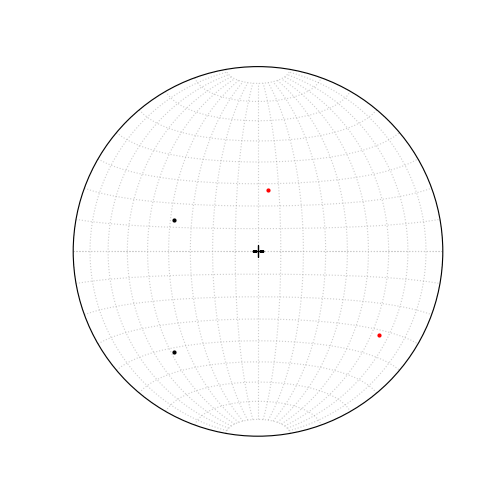

,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,-140.2214,0.1118,-30.0369,0.0766,8.824737e-15,1.394802e-17,250.277286,250.193492,5.377769
1,-69.4163,0.2615,-49.8524,0.1500,7.672073e-15,1.899259e-17,500.464368,500.502720,7.767939
2,9.0604,0.4988,62.3410,0.2187,6.312596e-15,1.988655e-17,750.727970,750.720446,8.572643
3,124.6274,0.3892,21.7600,0.2726,4.939015e-15,3.006855e-17,200.296017,800.923711,10.000332


In [26]:
# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
mx_FD_robust, my_FD_robust, mz_FD_robust, A_FD_robust, forward_model_FD_robust = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, data)
D_FD_robust, I_FD_robust = directions(mx_FD_robust, my_FD_robust, mz_FD_robust, plot=True)

#calculate momentum
momentum_FD_robust = (np.sqrt(mx_FD_robust**2 + my_FD_robust**2 + mz_FD_robust**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(data))+np.absolute(np.min(data))) * noise_std_dev
sigma_noise = noise_std_dev
sigma_D_FD_robust, sigma_I_FD_robust, sigma_m_FD_robust = uncertainties(sigma_noise, A_FD_robust, mx_FD_robust, my_FD_robust, mz_FD_robust)


df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_robust, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_robust, decimals=4)),
                        'Inc (°)': (np.round(I_FD_robust, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_robust, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_robust),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_robust),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)

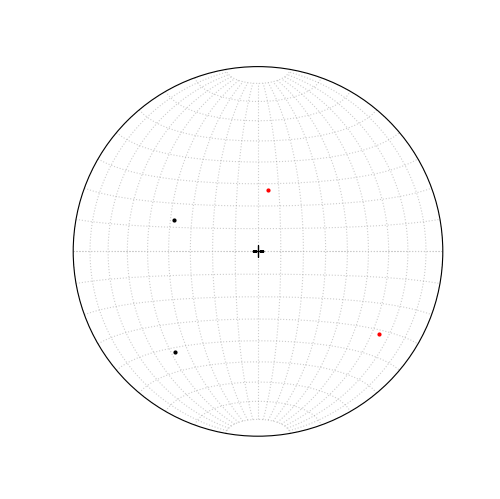

,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,-140.2682,0.2462,-30.0500,0.1686,8.802500e-15,3.062434e-17,250.277286,250.193492,5.377769
1,-69.4346,0.5069,-49.8418,0.2909,7.662416e-15,3.678279e-17,500.464368,500.502720,7.767939
2,9.3025,0.9352,62.3302,0.4102,6.302057e-15,3.723971e-17,750.727970,750.720446,8.572643
3,124.3980,0.6899,21.6338,0.4833,4.948856e-15,5.347638e-17,200.296017,800.923711,10.000332


In [27]:
# Magnetic inversion using FD euler positions and magnetic data after the upward continuation

mx_FD_up_robust, my_FD_up_robust, mz_FD_up_robust, A_FD_up_robust, forward_model_FD_up_robust = least_square_solver(X, Y, Z+delta_z, Xc_FD, Yc_FD, Zc_FD, upward)
D_FD_up_robust, I_FD_up_robust = directions(mx_FD_up_robust, my_FD_up_robust, mz_FD_up_robust, plot=True)

#calculate momentum
momentum_FD_up_robust = (np.sqrt(mx_FD_up_robust**2 + my_FD_up_robust**2 + mz_FD_up_robust**2))


#Inversion uncertainties
# sigma_noise = (np.absolute(np.max(data))+np.absolute(np.min(data))) * noise_std_dev
sigma_noise = noise_std_dev
sigma_D_FD_up_robust, sigma_I_FD_up_robust, sigma_m_FD_up_robust = uncertainties(sigma_noise, A_FD_up_robust, mx_FD_up_robust, my_FD_up_robust, mz_FD_up_robust)


df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_up_robust, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_up_robust, decimals=4)),
                        'Inc (°)': (np.round(I_FD_up_robust, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_up_robust, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_up_robust),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_up_robust),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(5)

# Article Figure

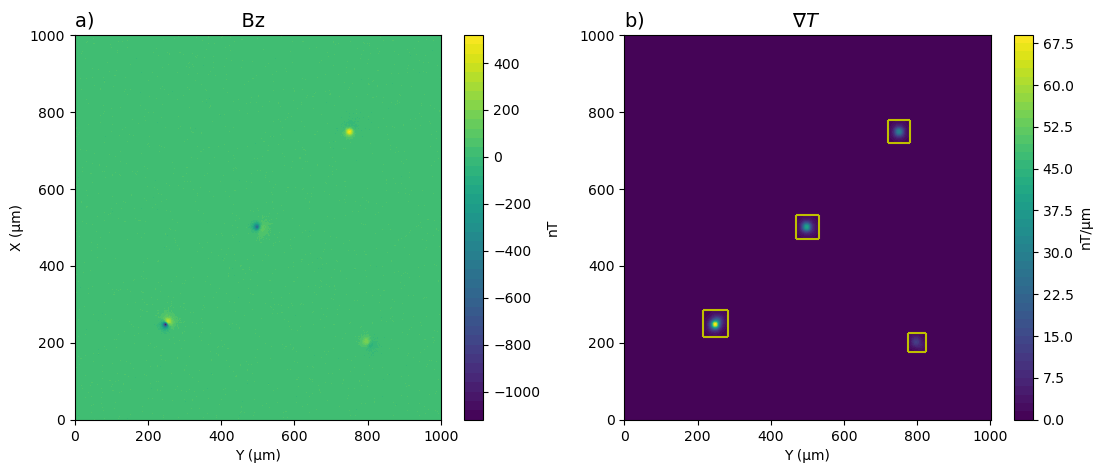

In [28]:
fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(13,5))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, data_2D*10**9, levels=50, cmap='viridis')
plt.colorbar(ax1_plot, ax=ax1, label='nT')
ax1.set_title('a)                        Bz', fontsize=14, loc='left')
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

# plot FFT horizontal gradient 
ax2_plot = ax2.contourf(x_plot, y_plot, Total_Grad_FD*1.0e3, levels=50, cmap='viridis')
plt.colorbar(ax2_plot, ax=ax2, label='nT/µm')
ax2.set_title(r'b)                        $\nabla T$', fontsize=14, loc='left')
ax2.set_xlabel('Y (µm)', fontsize=10)
#ax2.set_ylabel('X (µm)', fontsize=10)

# plot isolated windows 
nx, ny = np.shape(data_2D)
y_step = (np.max(Y_2D)*m2microm - np.min(Y_2D)*m2microm) / (ny-1)
x_step = (np.max(X_2D)*m2microm - np.min(X_2D)*m2microm) / (nx-1)
color='y'
for i in range(np.shape(euler_windows_FD)[0]):
    x1 = int(euler_windows_FD[i,0]) * x_step
    x2 = int(euler_windows_FD[i,1]) * x_step
    y1 = int(euler_windows_FD[i,2]) * y_step
    y2 = int(euler_windows_FD[i,3]) * y_step

    plt.hlines(x1, y1, y2, color=color)
    plt.hlines(x2, y1, y2, color=color)
    plt.vlines(y1, x1, x2, color=color)
    plt.vlines(y2, x1, x2, color=color)

image_name = 'SimpleSynthetic'    
import os
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
fig.savefig(my_path + '\\..\\..\\images\\'+ image_name + '.png', dpi=300, facecolor='w', bbox_inches='tight')

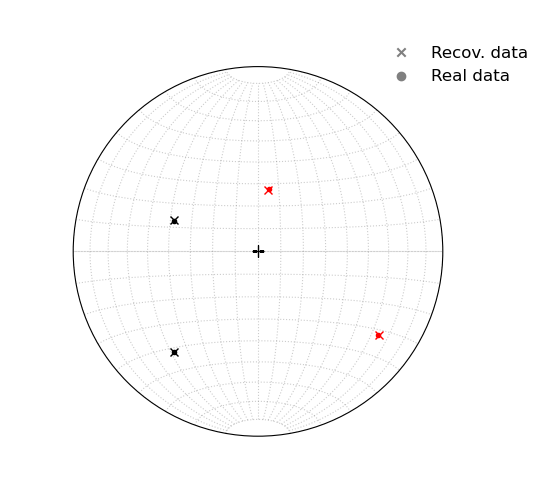

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')

for w in range (np.size(D)):
    if I[w] >= 0:
        symbol = '.'
        color = 'r'
    else:
        symbol = '.'
        color = 'k'

    if w == 0:
        ax.line(np.absolute(I[w]), D[w], color=color, marker=symbol)

    else:
        ax.line(np.absolute(I[w]), D[w],  color=color, marker=symbol)

        
        
for k in range (np.size(D_FD_least)):
    if I_FD_least[k] >= 0:
        symbol = 'x'
        color = 'r'
    else:
        symbol = 'x'
        color = 'k'

    if k == 0:
        ax.line(np.absolute(I_FD_least[k]), D_FD_least[k], color=color, marker=symbol)

    else:
        ax.line( np.absolute(I_FD_least[k]), D_FD_least[k], color=color, marker=symbol)

ax.line(90,90, marker='+', color='k', markersize=8) # center mark
ax.set_azimuth_ticks([])
ax.grid(which='both', linestyle=':', color='gray', alpha=0.4)

ax.scatter([],[], marker='x', color='gray', label='Recov. data')
ax.scatter([],[], marker='o', color='gray', label='Real data')

ax.legend(loc='upper left', bbox_to_anchor=(0.8, 1.1), frameon=False, fontsize=12)

ax.plot();

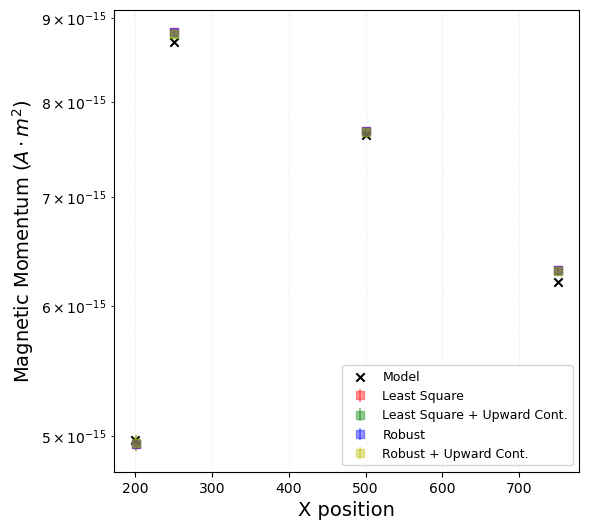

In [30]:
sources = np.copy(Xc_FD*m2microm)

moment_real = (np.array(M)*4/3*np.pi*np.array(R)**3)

plt.figure(figsize=(6,6))
plt.errorbar(sources, momentum_FD_least, sigma_m_FD_least, fmt='s', alpha=0.4, color='r', label='Least Square')
plt.errorbar(sources, momentum_FD_up_least, sigma_m_FD_up_least, fmt='s', alpha=0.4, color='g', label='Least Square + Upward Cont.')
plt.errorbar(sources, momentum_FD_robust, sigma_m_FD_robust, fmt='s', alpha=0.4, color='b', label='Robust')
plt.errorbar(sources, momentum_FD_up_robust, sigma_m_FD_up_robust, fmt='s', alpha=0.4, color='y', label='Robust + Upward Cont.' )

plt.scatter(np.array(Xc*m2microm), moment_real, marker='x', color='k', label='Model')

plt.legend(loc='lower right', fontsize=9)
plt.grid(alpha=0.3, linestyle=':')

plt.xlabel('X position', fontsize=14);
plt.ylabel('Magnetic Momentum ($A \cdot m^2$)', fontsize=14);

plt.yscale('log')


# Export Tables to LaTeX

In [31]:
my_path = os.path.abspath('') # Figures out the absolute path for you in case your working directory moves around.
table_path = (my_path + '\\..\\..\\')
print(table_path)

C:\Users\gelso\Desktop\Repositorios\inversion-microscopy\article_1\code\Synthetic\..\..\


# Simple synthetic table (model and solutions)

In [34]:
table_simple_synthetic = r"""
\begin{table}[htbp]
\caption{Each source positioning and magnetization parameters modelled and recovered using least square estimator, respectively.}
\label{tab:SimpleSyntheic}
\resizebox{1.0\textwidth}{!}{
\begin{tabular}{ccccccc}
\hline   
\rowcolor[HTML]{FFFFFF} 
\cellcolor[HTML]{FFFFFF}                         & \multicolumn{3}{c}{\cellcolor[HTML]{FFFFFF}Center coordinates} & \multicolumn{3}{c}{\cellcolor[HTML]{FFFFFF}Magnetization}    \\
\rowcolor[HTML]{FFFFFF} 
\multirow{-2}{*}{\cellcolor[HTML]{FFFFFF}Sphere} & Xc ($\mu   m$)     & Yc ($\mu   m$)     & Zc ($\mu   m$)    & m ($A \cdot m^2$)       & D (\textdegree)          & I (\textdegree)           \\  \hline 
\multirow{2}{*}{1}                               & %s                 & %s                 & %s                & \multicolumn{1}{l}{%s}  & \multicolumn{1}{l}{%s}   & \multicolumn{1}{l}{%s}    \\ 
                                                 & %s                 & %s                 & %s                & %s  $\pm$  %s           & %s  $\pm$  %s            & %s    $\pm$  %s           \\  \hline 
\multirow{2}{*}{2}                               & %s                 & %s                 & %s                & \multicolumn{1}{l}{%s}  & \multicolumn{1}{l}{%s}   & \multicolumn{1}{l}{%s}    \\ 
                                                 & %s                 & %s                 & %s                & %s  $\pm$  %s           & %s  $\pm$  %s            & %s    $\pm$  %s           \\  \hline 
\multirow{2}{*}{3}                               & %s                 & %s                 & %s                & \multicolumn{1}{l}{%s}  & \multicolumn{1}{l}{%s}   & \multicolumn{1}{l}{%s}    \\
                                                 & %s                 & %s                 & %s                & %s  $\pm$  %s           & %s  $\pm$  %s            & %s    $\pm$  %s           \\  \hline 
\multirow{2}{*}{4}                               & %s                 & %s                 & %s                & \multicolumn{1}{l}{%s}  & \multicolumn{1}{l}{%s}   & \multicolumn{1}{l}{%s}    \\
                                                 & %s                 & %s                 & %s                & %s  $\pm$  %s           & %s  $\pm$  %s            & %s    $\pm$  %s           \\  \hline
\end{tabular}
}
\end{table}

"""%('{:.2f}'.format(Xc_[0]), '{:.2f}'.format(Yc_[0]), '{:.2f}'.format(Zc_[0]), '{:.2e}'.format(moment_real[0]), '{:.2f}'.format(D[0]), '{:.2f}'.format(I[0]),
     '{:.2f}'.format(Xc_FD_[0]), '{:.2f}'.format(Yc_FD_[0]), '{:.2f}'.format(Zc_FD_[0]), '{:.2e}'.format(momentum_FD_least[0]), '{:.2e}'.format(sigma_m_FD_least[0]), '{:.2f}'.format(D_FD_least[0]),'{:.2f}'.format(sigma_D_FD_least[0]), '{:.2f}'.format(I_FD_least[0]),'{:.2f}'.format(sigma_I_FD_least[0]),
     '{:.2f}'.format(Xc_[1]), '{:.2f}'.format(Yc_[1]), '{:.2f}'.format(Zc_[1]), '{:.2e}'.format(moment_real[1]), '{:.2f}'.format(D[1]), '{:.2f}'.format(I[1]),
     '{:.2f}'.format(Xc_FD_[1]), '{:.2f}'.format(Yc_FD_[1]), '{:.2f}'.format(Zc_FD_[1]), '{:.2e}'.format(momentum_FD_least[1]), '{:.2e}'.format(sigma_m_FD_least[1]), '{:.2f}'.format(D_FD_least[1]),'{:.2f}'.format(sigma_D_FD_least[1]), '{:.2f}'.format(I_FD_least[1]),'{:.2f}'.format(sigma_I_FD_least[1]),
     '{:.2f}'.format(Xc_[2]), '{:.2f}'.format(Yc_[2]), '{:.2f}'.format(Zc_[2]), '{:.2e}'.format(moment_real[2]), '{:.2f}'.format(D[2]), '{:.2f}'.format(I[2]),
     '{:.2f}'.format(Xc_FD_[2]), '{:.2f}'.format(Yc_FD_[2]), '{:.2f}'.format(Zc_FD_[2]), '{:.2e}'.format(momentum_FD_least[2]), '{:.2e}'.format(sigma_m_FD_least[2]), '{:.2f}'.format(D_FD_least[2]),'{:.2f}'.format(sigma_D_FD_least[2]), '{:.2f}'.format(I_FD_least[2]),'{:.2f}'.format(sigma_I_FD_least[2]),
     '{:.2f}'.format(Xc_[3]), '{:.2f}'.format(Yc_[3]), '{:.2f}'.format(Zc_[3]), '{:.2e}'.format(moment_real[3]), '{:.2f}'.format(D[3]), '{:.2f}'.format(I[3]),
     '{:.2f}'.format(Xc_FD_[3]), '{:.2f}'.format(Yc_FD_[3]), '{:.2f}'.format(Zc_FD_[3]), '{:.2e}'.format(momentum_FD_least[3]), '{:.2e}'.format(sigma_m_FD_least[3]), '{:.2f}'.format(D_FD_least[3]),'{:.2f}'.format(sigma_D_FD_least[3]), '{:.2f}'.format(I_FD_least[3]),'{:.2f}'.format(sigma_I_FD_least[3])
    )

f = open(table_path+"simple_synthetic_table.tex", "w")
f.write(table_simple_synthetic)
f.close()
